In [27]:
library(quantmod)
library(forecast)
library(tseries)
library(prophet)
library(dplyr)

In [28]:
getSymbols('FXPO.L')
df <- subset(FXPO.L,sel='FXPO.L.Close')
df <- na.omit(df)
tail(df)

Warning message:
“FXPO.L contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them.”

[1] "FXPO.L"

           FXPO.L.Close
2017-12-15        266.7
2017-12-18        281.1
2017-12-19        281.4
2017-12-20        285.4
2017-12-21        289.0
2017-12-22        287.8

In [29]:
adf.test(df, alternative=c('stationary'))


	Augmented Dickey-Fuller Test

data:  df
Dickey-Fuller = -1.7295, Lag order = 13, p-value = 0.6929
alternative hypothesis: stationary


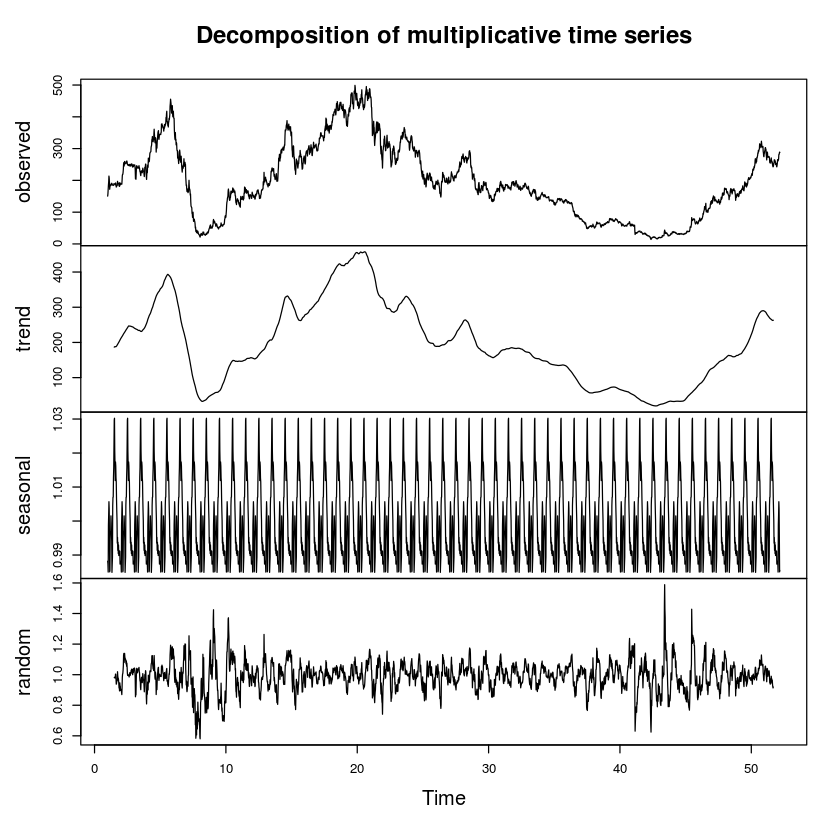

In [30]:
d <- ts(df,frequency=52)
plot(decompose(d, type="multiplicative"))

In [31]:
freq <- 52

In [32]:
L <- BoxCox.lambda(ts(df, frequency=365), method="loglik")
L

[1] 0.55

In [33]:
# Fit ARIMA, NN and ETS for short-run
short <- ts(df[index(df) > "2017-11-01" & index(df) < "2017-12-01"], frequency=freq)
short.test <- as.numeric(df[index(df) >= "2017-12-01",])
h <- length(short.test)

In [34]:
fit.arima <- auto.arima(short, lambda=L)
fcast.arima <- forecast(fit.arima, h, lambda=L)

Warning message in InvBoxCox(pred$pred, lambda, biasadj, var(residuals(object), :
“biasadj information not found, defaulting to FALSE.”

In [35]:
#acf(df)

In [36]:
fit.nn <- nnetar(short, size=7, lambda=L)
fcast.nn <- forecast(fit.nn, h, lambda=L)

Warning message in nnetar(short, size = 7, lambda = L):
“Series too short for seasonal lags”

In [37]:
fit.tbats <-tbats(short, lambda=L)
fcast.tbats <- forecast(fit.tbats, h, lambda=L)

In [52]:
d <- data.frame(date=index(df), coredata(df))
d <- head(d,-h)
#print(tail(d))
colnames(d) <- c('ds','y')
dd <- tail(d,-h)
print(tail(dd))

             ds     y
2641 2017-11-23 263.0
2642 2017-11-24 263.9
2643 2017-11-27 261.4
2644 2017-11-28 259.7
2645 2017-11-29 249.9
2646 2017-11-30 253.4


In [39]:
we <- seq(as.Date('2007-01-01'),as.Date('2017-12-31'),by = 1)
we <- we[!weekdays(we) %in% c('Saturday','Sunday')]
bankHol <- as.Date(c('2017-12-25','2017-12-26','2018-01-01',
                '2018-03-30','2018-04-02','2018-05-07',
                '2018-05-28','2018-08-27','2018-12-25',
                '2018-12-26','2019-01-01'))
holiday <- c(we,bankHol)
holidays <- data_frame(
  holiday = 'playoff',
  ds = holiday,
  lower_window = 0,
  upper_window = 0
)

In [99]:
ds <- seq(as.Date('2017-12-01'),as.Date('2017-12-01')+h-1,by = 1)
fcast.arima$Point <- ds
fcast.arima

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
1.403846       254.1719 246.7175 261.7261 242.8118 265.7653
1.423077       254.8087 245.9887 263.7682 241.3764 268.5674
1.442308       255.2685 245.8130 264.8842 240.8727 270.0392
1.461538       255.6004 245.8286 265.5432 240.7252 270.8757
1.480769       255.8399 245.9062 265.9504 240.7193 271.3738
1.500000       256.0128 245.9948 266.2103 240.7646 271.6810
1.519231       256.1375 246.0754 266.3808 240.8224 271.8763
1.538462       256.2275 246.1420 266.4949 240.8769 272.0035
1.557692       256.2924 246.1944 266.5727 240.9229 272.0883
1.576923       256.3393 246.2346 266.6265 240.9596 272.1458
1.596154       256.3731 246.2647 266.6640 240.9878 272.1854
1.615385       256.3974 246.2870 266.6905 241.0091 272.2130
1.634615       256.4150 246.3035 266.7093 241.0249 272.2324
1.653846       256.4277 246.3155 266.7226 241.0366 272.2461
1.673077       256.4369 246.3243 266.7322 241.0452 272.2559
1.692308       256.4435 246.3306 266.739

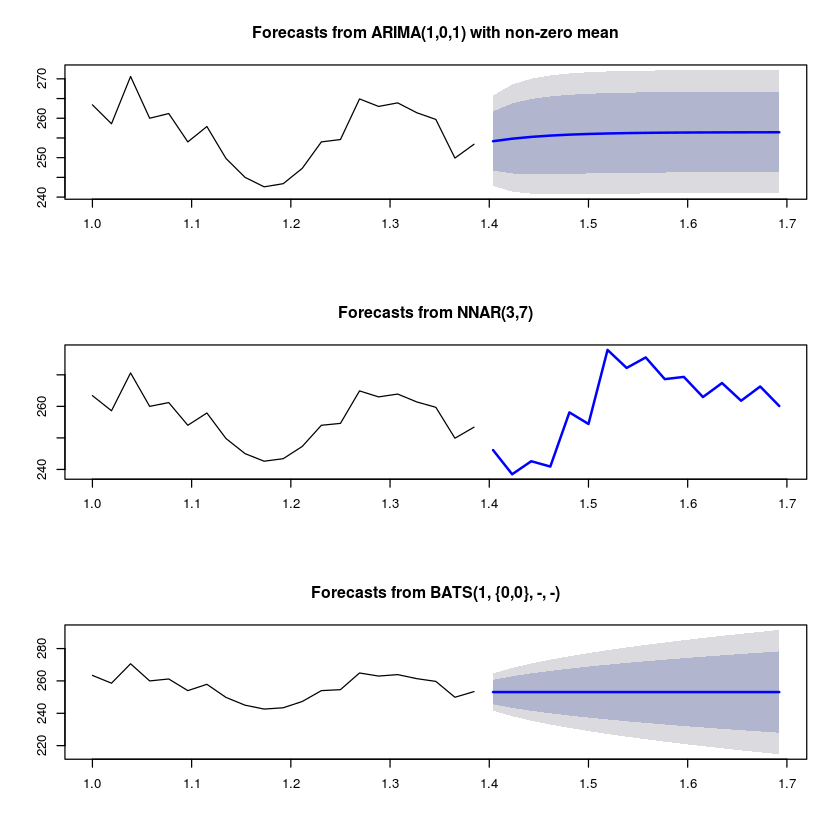

In [41]:
par(mfrow=c(3, 1))
plot(fcast.arima, include=3*h)
plot(fcast.nn, include=3*h)
plot(fcast.tbats, include=3*h)

In [53]:
m <- prophet(d,holidays=holidays)
future <- make_future_dataframe(m, periods = h)
forecast <- predict(m, future)
tail(forecast[c('ds', 'yhat', 'yhat_lower', 'yhat_upper')],h)

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.


Initial log joint probability = -92.7411
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


,ds,yhat,yhat_lower,yhat_upper
2647,2017-12-01,240.1748,193.6980,290.3964
2648,2017-12-02,216.8219,167.2687,266.3458
2649,2017-12-03,217.0908,166.5069,263.6477
2650,2017-12-04,240.7607,196.0498,287.6046
2651,2017-12-05,240.7550,187.8725,285.9506
2652,2017-12-06,240.8978,194.5659,290.5175
2653,2017-12-07,241.1057,193.1447,287.8988
2654,2017-12-08,241.1495,195.1438,285.1580
2655,2017-12-09,217.3859,170.7529,265.3178
2656,2017-12-10,217.2965,170.5034,260.4473


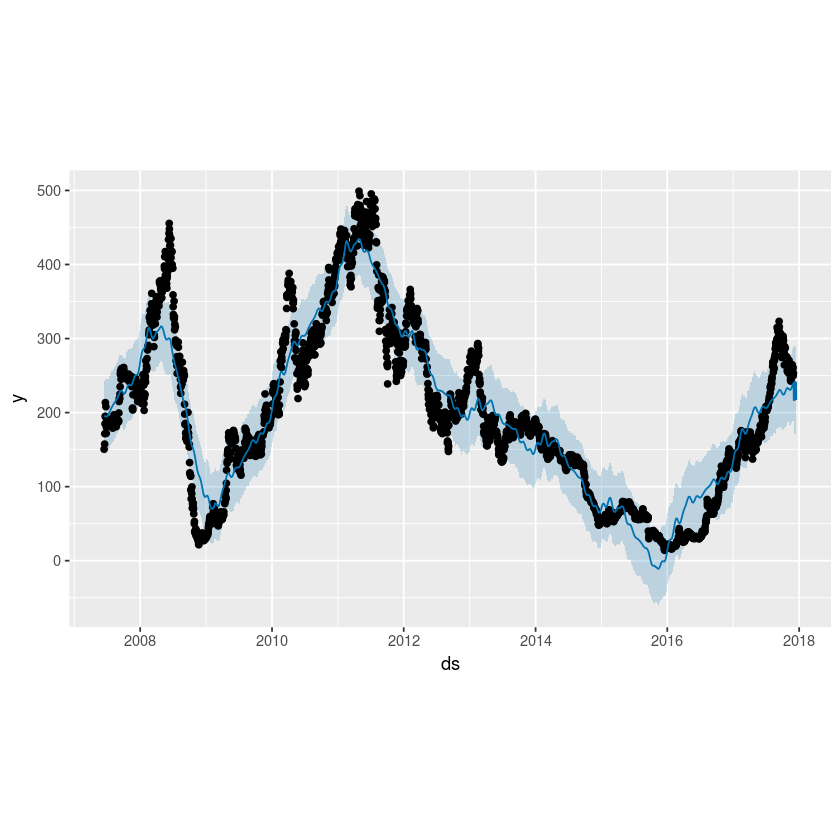

In [54]:
#m <- tail(m,freq)
#forecast <- tail(forecast,freq)
plot(m,forecast)

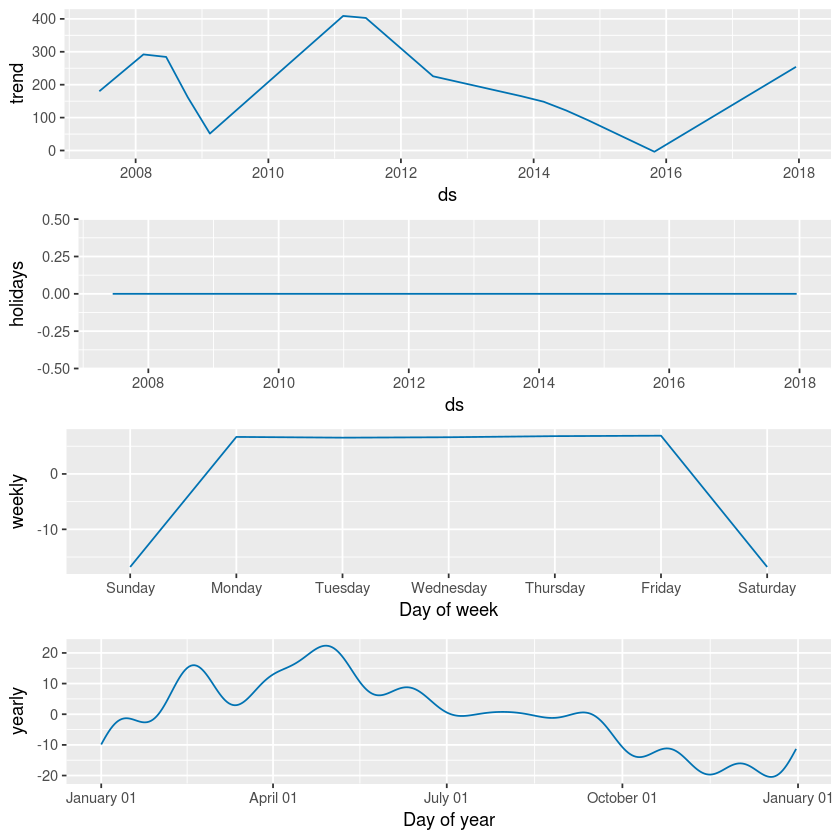

In [55]:
prophet_plot_components(m, forecast)

 [1] 254.1719 254.8087 255.2685 255.6004 255.8399 256.0128 256.1375 256.2275
 [9] 256.2924 256.3393 256.3731 256.3974 256.4150 256.4277 256.4369 256.4435


[1] 4.984275

 [1] 246.1267 238.4682 242.5968 240.9053 258.0845 254.4142 277.9015 272.1887
 [9] 275.5174 268.6379 269.3440 262.9529 267.3943 261.7829 266.3004 260.1073


[1] 4.272575

 [1] 253.1001 253.1001 253.1001 253.1001 253.1001 253.1001 253.1001 253.1001
 [9] 253.1001 253.1001 253.1001 253.1001 253.1001 253.1001 253.1001 253.1001


[1] 5.483732

[1] "list"

,ds,yhat
2647,2017-12-01,240.1748
2648,2017-12-02,216.8219
2649,2017-12-03,217.0908
2650,2017-12-04,240.7607
2651,2017-12-05,240.7550
2652,2017-12-06,240.8978
2653,2017-12-07,241.1057
2654,2017-12-08,241.1495
2655,2017-12-09,217.3859
2656,2017-12-10,217.2965


NULL


[1] 0

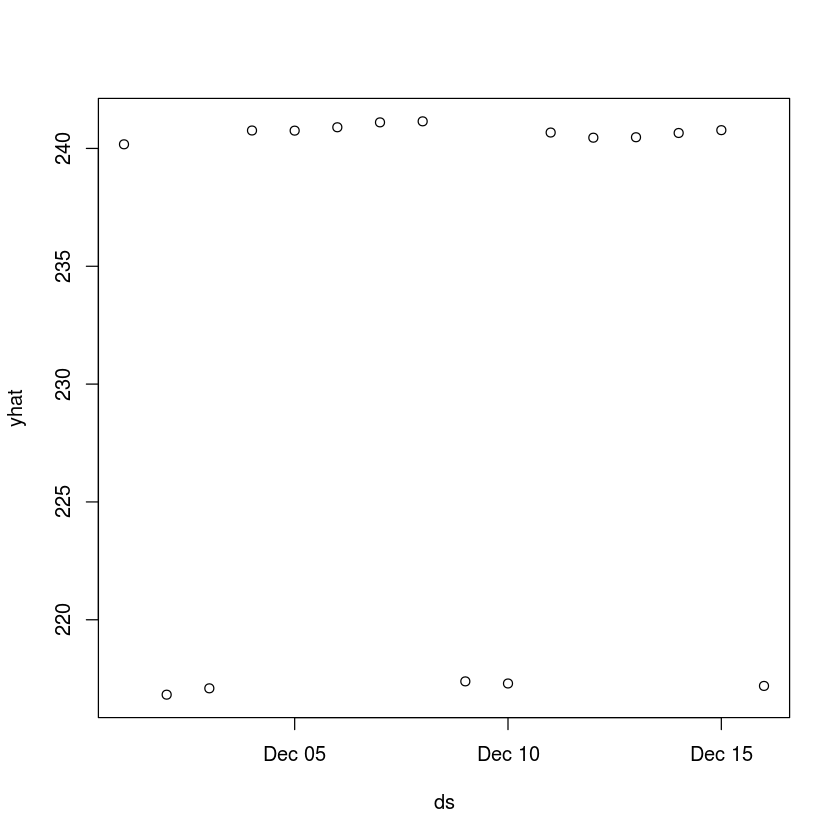

In [74]:
mape <- function(r, f){
  len <- length(r)
  print(f$mean[1:len])
  return(sum(abs(r-f$mean[1:len])/r)/len*100)
}

mape(short.test, fcast.arima)
mape(short.test, fcast.nn)
mape(short.test, fcast.tbats)
fcast <- tail(forecast[c('ds','yhat')],h)
typeof(fcast)
fcast
mape(short.test,fcast)

In [66]:
Stl = Stl(df,s.window=”periodic”)

ERROR: Error in parse(text = x, srcfile = src): <text>:1:23: unexpected input
1: Stl = Stl(df,s.window=<e2>
                          ^


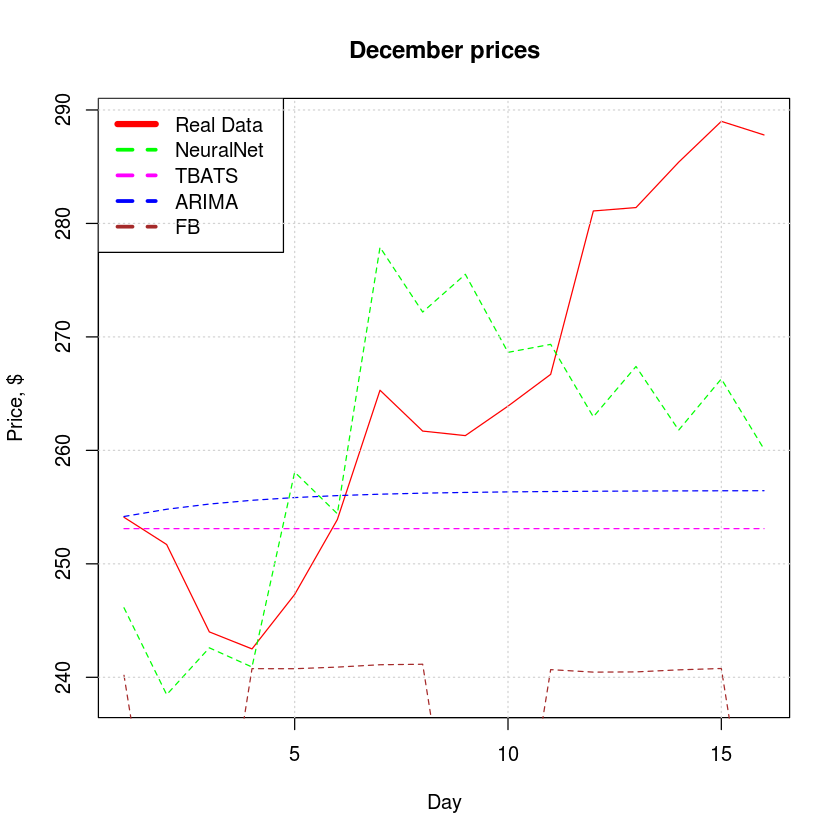

In [75]:
par(mfrow=c(1, 1))
plot(short.test, type="l", col="red", lwd=1, xlab="Day", ylab="Price, $", main="December prices",
     ylim=c(min(short.test, fcast.arima$mean, fcast.tbats$mean, fcast.nn$mean),
            max(short.test, fcast.arima$mean, fcast.tbats$mean, fcast.nn$mean)))
lines(as.numeric(fcast.nn$mean), col="green", lwd=1,lty=2)
lines(as.numeric(fcast.tbats$mean), col="magenta", lwd=1,lty=2)
lines(as.numeric(fcast.arima$mean), col="blue", lwd=1, lty=2)
lines(tail(as.numeric(forecast$yhat),h),col="brown",lwd=1,lty=2)
legend("topleft", legend=c("Real Data","NeuralNet","TBATS", "ARIMA",'FB'), 
       col=c("red","green", "magenta","blue",'brown'), lty=c(1,2,2,2,2), lwd=c(5,3,3,3,3))
grid()

In [46]:
nfl_sunday <- function(ds) {
  dates <- as.Date(ds)
  month <- as.numeric(format(dates, '%m'))
  as.numeric((weekdays(dates) == "Sunday") & (month > 8 | month < 2))
}
d$nfl_sunday <- nfl_sunday(d$ds)

m <- prophet()
m <- add_regressor(m, 'nfl_sunday')
m <- fit.prophet(m, d)

future$nfl_sunday <- nfl_sunday(future$ds)

forecast <- predict(m, future)
prophet_plot_components(m, forecast)

ERROR: Error in initialize_scales_fn(m, initialize_scales, df): Regressor nfl_sunday is constant.


# Another gas test

In [ ]:
gas <- read.csv('gas.csv',header=F)
colnames(gas) <- c('ds','y')
gas$ds <- as.Date(gas$ds,"%d.%m.%y")
#gas

In [ ]:
m <- prophet(gas)
future <- make_future_dataframe(m, freq = 'month', periods = 12, include_history = FALSE)
forecast <- predict(m, future)
forecast[c('ds', 'yhat', 'yhat_lower', 'yhat_upper')]
#plot(m,forecast)
#prophet_plot_components(m, forecast)

In [ ]:
g <- xts(gas$y, order.by=gas$ds)
fit.arima <- auto.arima(g)
h=12
fcast.arima <- forecast(fit.arima, h)
#plot(fcast.arima, include=3*h)
fcast.arima
#plot(fcast.arima)